[View in Colaboratory](https://colab.research.google.com/github/miguelrq/GANs/blob/master/WGAN-GP-CIFAR10.ipynb)

In [1]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 12.8MB/s 


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [0]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


In [0]:
os.makedirs('images', exist_ok=True)


n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 32
channels = 3
n_critic = 0.01
clip_value = 0.01
sample_interval = 800


In [0]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [  nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [8]:
# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs('../../data/CIFAR10', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../../data/CIFAR10', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [0]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [0]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=fake, create_graph=True, retain_graph=True,
                              only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [15]:
# ----------
#  Training
# ----------

d_learning = []
g_learning = []

batches_done = 0

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)
        
        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

             # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs,
                                                            i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))
            d_learning.append(d_loss.item())
            g_learning.append(g_loss.item())
        
        
        
        if batches_done % sample_interval == 0:
            save_image(fake_imgs.data[:25], 'images/%08d.png' % batches_done, nrow=5, normalize=True)
        batches_done += n_critic
        
        
        
       

[Epoch 0/200] [Batch 0/782] [D loss: 9.044521] [G loss: 0.020662]
[Epoch 1/200] [Batch 0/782] [D loss: -5674.529785] [G loss: 37.876080]
[Epoch 2/200] [Batch 0/782] [D loss: -7830.753906] [G loss: -14.337216]
[Epoch 3/200] [Batch 0/782] [D loss: -10704.054688] [G loss: -7.087642]
[Epoch 4/200] [Batch 0/782] [D loss: -10223.500000] [G loss: 108.169777]
[Epoch 5/200] [Batch 0/782] [D loss: -11395.434570] [G loss: 66.842178]
[Epoch 6/200] [Batch 0/782] [D loss: -12135.519531] [G loss: -2.534059]
[Epoch 7/200] [Batch 0/782] [D loss: -10986.583984] [G loss: -33.281681]
[Epoch 8/200] [Batch 0/782] [D loss: -12105.499023] [G loss: -123.994438]
[Epoch 9/200] [Batch 0/782] [D loss: -12346.224609] [G loss: -146.615845]
[Epoch 10/200] [Batch 0/782] [D loss: -12045.863281] [G loss: -314.093048]
[Epoch 11/200] [Batch 0/782] [D loss: -11580.706055] [G loss: -391.617706]
[Epoch 12/200] [Batch 0/782] [D loss: -11709.899414] [G loss: -517.145752]
[Epoch 13/200] [Batch 0/782] [D loss: -12275.787109] [G 

In [16]:
!ls images

00000000.png  00013600.png  00027200.png  00040800.png	00054400.png
00000800.png  00014400.png  00028000.png  00041600.png	00055200.png
00001600.png  00015200.png  00028800.png  00042400.png	00056000.png
00002400.png  00016000.png  00029600.png  00043200.png	00056800.png
00003200.png  00016800.png  00030400.png  00044000.png	00057600.png
00004000.png  00017600.png  00031200.png  00044800.png	00058400.png
00004800.png  00018400.png  00032000.png  00045600.png	00059200.png
00005600.png  00019200.png  00032800.png  00046400.png	00060000.png
00006400.png  00020000.png  00033600.png  00047200.png	00060800.png
00007200.png  00020800.png  00034400.png  00048000.png	00061600.png
00008000.png  00021600.png  00035200.png  00048800.png	00062400.png
00008800.png  00022400.png  00036000.png  00049600.png	00063200.png
00009600.png  00023200.png  00036800.png  00050400.png	00064000.png
00010400.png  00024000.png  00037600.png  00051200.png	00064800.png
00011200.png  00024800.png  00038400.png  000520

In [17]:
!ls images/ -l . | egrep -c '^-'

84


In [0]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('images/*.png'): #assuming gif
    im=Image.open(filename)
    image_list.append(im)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def get_sample(array,x):
  steps = int(len(array)/(x-1))
  print(steps)
  new_array = []
  for i in range(0,x-1):
    print("-",i*steps)
    new_array.append(array[i*steps])
  new_array.append(array[-1])
  print(steps)
  print(len(new_array))
  return new_array

1
- 0
- 1
- 2
- 3
- 4
- 5
- 6
- 7
- 8
- 9
- 10
- 11
- 12
- 13
- 14
- 15
- 16
- 17
- 18
- 19
- 20
- 21
- 22
- 23
- 24
- 25
- 26
- 27
- 28
- 29
- 30
- 31
- 32
- 33
- 34
- 35
- 36
- 37
- 38
- 39
- 40
- 41
- 42
- 43
- 44
- 45
- 46
- 47
1
49


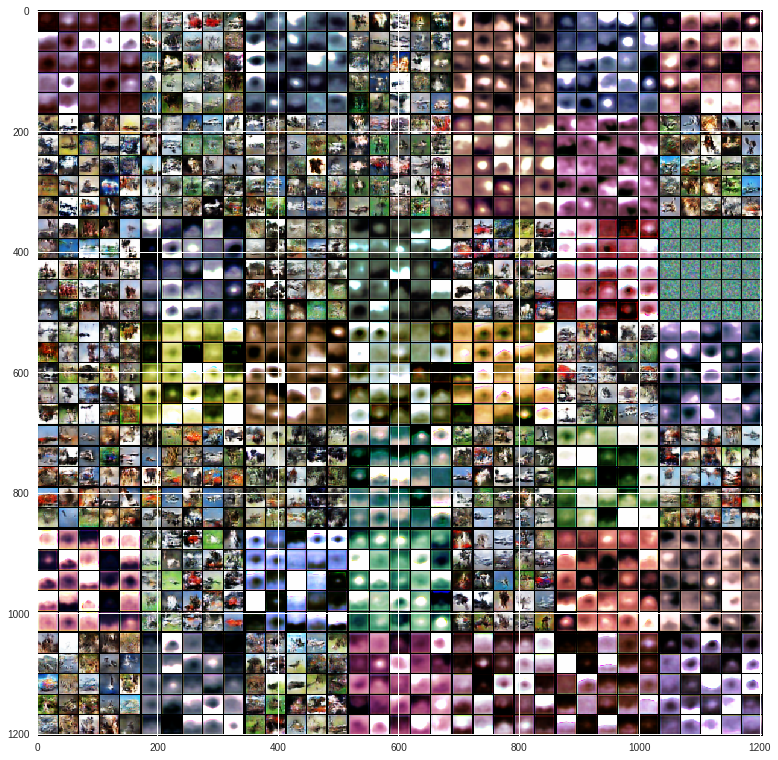

In [25]:

def gallery(array, ncols=7):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array(image_array):      
    return np.array([np.array(img) for img in image_array])    

array = make_array(get_sample(image_list,49))
result = gallery(array)
plt.figure(figsize=(13,20))
plt.imshow(result)
plt.show()

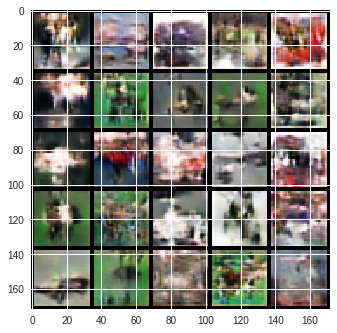

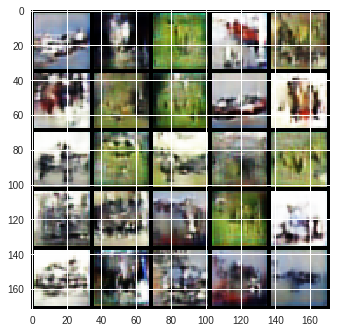

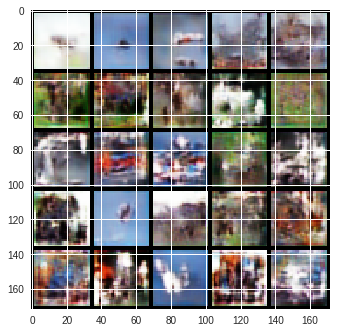

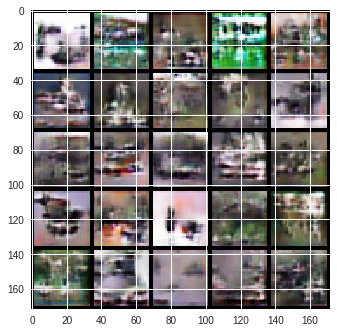

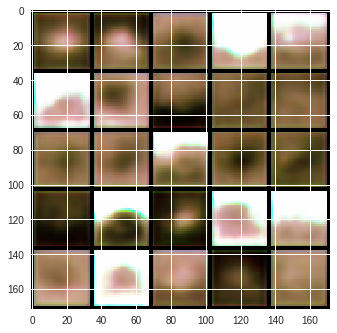

In [31]:
plt.imshow(image_list[10])
plt.show()
plt.imshow(image_list[-4])
plt.show()
plt.imshow(image_list[-5])
plt.show()
plt.imshow(image_list[-6])
plt.show()
plt.imshow(image_list[-7])
plt.show()

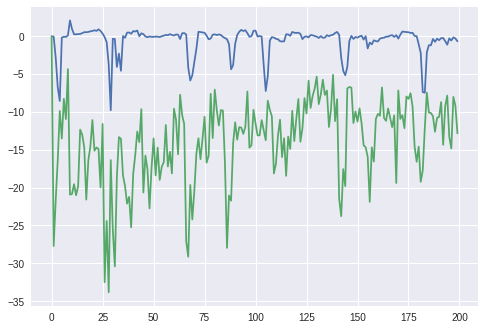

In [0]:
plt.plot(g_learning)
plt.plot(d_learning)
plt.show()